# Capstone Project - Machine Learning Nanodegree

## Convolutional Neural Networks - Thorax-Pneumonia Classifier

---

### Introduction

In this notebook, we are developing a deep learning classification algorithm. Specific models learn a mapping between input features and class labels. The coding shall accept any future (posterior-anterior, anterior-posterior orientations) X-ray chest image as input for estimation of having a pneumonia chest image or not. Regarding the underlying dataset, we are solving such binary classification question for .jpeg compressed X-ray chest images mostly from children. This dataset used for analysis comes from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/version/2). Such kind of analysis result improves the medical diagnostic workflow. As a future improvement, the algorithm could be used for all human age categories and X-ray orientations including lateral chest images, but such images are not available by now.

![Image Samples](images/lung_images_pair_small.PNG)


For official companies the medical software development happened as part of a regulatory domain. So, let us assume, we would like to use the algorithm as a component of an official product. Then notified bodies would proof the algorithm and its concept regarding quality and regulatory aspects. From technical point of view, working with medical images the CNN concept is the state-of-the-art approach. On the other hand, for getting an official permission and its discussion, the comparison and benchmark of several network architectures and parameter changes together with explanations would help. So, let us do this now.


For implementation on Windows OS, we use Python 3.6 with Keras and TensorFlow as backend. For plotting the network architecture the pydot library and Graphviz2.38 shall be installed and properly configured (see [readme](https://github.com/IloBe/CNN_Thorax-Pneumonia_Classifier/blob/master/README.md)).

---

### Navigation Content

* [Step 0](#step0): Import Libraries and Reproducibility
* [Step 1](#step1): Import Chest Dataset
* [Step 2](#step2): Data Exploration
* [Step 3](#step3): Data Pre-Processing
* [Step 4](#step4): Create a CNN Model from the Scratch (Basic Model)
* [Step 5](#step5): Last Basic Model with Augmentation
* [Step 6](#step6): Such Basic Model with Adam as Optimiser
* [Step 7](#step7): Last Basic Model with Adam and Augmentation
* [Step 8](#step8): Create an improved CNN Model with Adam
* [Step 9](#step9): Last improved CNN Model with Augmentation
* [Step 10](#step10): Create a ResNet CNN Model with Transfer Learning
* [Step 11](#step11): Fine-tuned Transfer Learning ResNet CNN Model with Augmentation
* [Step 12](#step12): Create an InceptionV3 CNN Model with Transfer Learning
* [Step 13](#step13): Evaluation
* [Step 14](#step14): Benchmark and Conclusion


---
<a id='step0'></a>
## Step 0: Import Libraries and Reproducibility

### Import Libraries
Import libraries needed to implement the algorithm for this Chest image classifier. Finally, set random seed to make the results reproducible. Note: Message pops up that TensorFlow backend is used.

In [1]:
from sklearn.datasets import load_files 
from sklearn import metrics
from glob import glob
from tqdm import tqdm
from PIL import ImageFile

from keras.utils import np_utils, plot_model
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import backend as K

from models.Model import Model
from Evaluation_Class import Evaluation_Class

import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt                        
%matplotlib inline 

import pandas as pd
import numpy as np
import random as rn
import tensorflow as tf
import pydot

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

Using TensorFlow backend.


### Make the Code Reproducible 

According Keras documentation this additional coding is necessary to make the results reproducible.

In [2]:
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(1042)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

<a id='step1'></a>
## Step 1: Import Chest Dataset

In the code cell below, we import a dataset of chest images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `chest_names` - list of string-valued chest names (NORMAL, PNEUMONIA) for translating labels

In [3]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    chest_files = np.array(data['filenames'])
    chest_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return chest_files, chest_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/chest_xray/train')
valid_files, valid_targets = load_dataset('data/chest_xray/val')
test_files, test_targets = load_dataset('data/chest_xray/test')

# load list of chest names (NORMAL, PNEUMONIA)
chest_names = [item[20:-1] for item in sorted(glob("data/chest_xray/train/*/"))]

In [4]:
#print(valid_files)

['data/chest_xray/val\\NORMAL\\NORMAL2-IM-1430-0001.jpeg'
 'data/chest_xray/val\\NORMAL\\NORMAL2-IM-1440-0001.jpeg'
 'data/chest_xray/val\\PNEUMONIA\\person1946_bacteria_4874.jpeg'
 'data/chest_xray/val\\PNEUMONIA\\person1946_bacteria_4875.jpeg'
 'data/chest_xray/val\\PNEUMONIA\\person1951_bacteria_4882.jpeg'
 'data/chest_xray/val\\NORMAL\\NORMAL2-IM-1437-0001.jpeg'
 'data/chest_xray/val\\NORMAL\\NORMAL2-IM-1431-0001.jpeg'
 'data/chest_xray/val\\PNEUMONIA\\person1952_bacteria_4883.jpeg'
 'data/chest_xray/val\\PNEUMONIA\\person1947_bacteria_4876.jpeg'
 'data/chest_xray/val\\NORMAL\\NORMAL2-IM-1442-0001.jpeg'
 'data/chest_xray/val\\PNEUMONIA\\person1954_bacteria_4886.jpeg'
 'data/chest_xray/val\\PNEUMONIA\\person1949_bacteria_4880.jpeg'
 'data/chest_xray/val\\NORMAL\\NORMAL2-IM-1436-0001.jpeg'
 'data/chest_xray/val\\NORMAL\\NORMAL2-IM-1427-0001.jpeg'
 'data/chest_xray/val\\NORMAL\\NORMAL2-IM-1438-0001.jpeg'
 'data/chest_xray/val\\PNEUMONIA\\person1950_bacteria_4881.jpeg']


In [6]:
# store the dataset files as csv, so, distribution of train-validation-test datasets are reproducible
# file names have to be changed according the used specific datasets distribution
# files are stored by using the sets first time

train_df = pd.DataFrame(train_files)
valid_df = pd.DataFrame(valid_files)
test_df = pd.DataFrame(test_files)

train_df.to_csv(path_or_buf="./requirements/train_original.csv", index=False)
valid_df.to_csv(path_or_buf="./requirements/valid_original.csv", index=False)
test_df.to_csv(path_or_buf="./requirements/test_original.csv", index=False)

<a id='step2'></a>
## Step 2: Data Exploration

Some statistical information about the dataset of chest images. 

In [7]:
def get_percentage(total, other):
    return (other*100)/total    

In [15]:
# print statistics about the dataset
# print('There are {} total chest categories, called: {}, {}.'.format(len(chest_names),chest_names[0],chest_names[1]))
print('There are %d total chest categories' % len(chest_names))  # there are only 2
total = len(np.hstack([train_files, valid_files, test_files]))
print('There are %s total chest images.\n' % (total))
print('There are %d training chest images: %.3f%%' % (len(train_files),
                                                      get_percentage(total, len(train_files))))
print('There are %d validation chest images: %.3f%%' % (len(valid_files),
                                                        get_percentage(total, len(valid_files))))
print('There are %d test chest images: %.3f%%'% (len(test_files),
                                                 get_percentage(total, len(test_files))))

There are 2 total chest categories
There are 5856 total chest images.

There are 5216 training chest images: 89.071%
There are 16 validation chest images: 0.273%
There are 624 test chest images: 10.656%


**Note:**<br>
According the original dataset 89.07% are training images and only 10.66% are test images. This doesn't fit to the rule-of-thumb to use a training/testing separation of 70/30 or 80/20 percent. 
But first, we will have look how the results for the different CNN are working with this original dataset.

As another distribution, as basic for creating the 60-20-20 data version of training-validation-test sets:<br>
Therefore, this distribution has been changed to the 80/20 ratio. Regarding the second separation of being normal or pneumonia ones (resp. root cause virus or bacteria), the same distribution ratio as before has been choosen. The images moved to the other directories have been selected randomly.

80% training images = 4684.8  => 4685  => division by 32: 146 x 32 = 4672; therefore in the new training set 4672 images are available<br>
20% test images = 1171.2,  but some are moved to the validation set now. In the original dataset no virus chest images are included to the validation set. Now there are some and some more bacteria chest images.

How are the categories labelled? Regarding the images, for the different training, testing and validation pneumonia data samples, the images are labelled with 'virus' and 'bacteria' as root cause. This information is part of the image name text string. How many are there from each root cause category? The categories are ...

In [16]:
# What kind of chest categories exist?
chest_names

['n\\NORMAL', 'n\\PNEUMONIA']

What is the structure of the files from the different directories, means how many images from each category are available in the train, validation and test directories?

In [17]:
def get_category_counter(file):
    ''' delivers the amount of normal or pneumonia images '''
    counter_normal = 0
    counter_pneumonia = 0
    file_array = file
    pneumonia_files = []
        
    for item in file_array[:]:
        if 'NORMAL' in item:
            counter_normal += 1
        else: # PNEUMONIA case
            # add item to array and increase counter
            pneumonia_files.append(item)
            counter_pneumonia += 1
               
    return counter_normal, counter_pneumonia, pneumonia_files

count_train_normal, count_train_pneumonia, train_pneumonia_files = get_category_counter(train_files)
count_valid_normal, count_valid_pneumonia, valid_pneumonia_files = get_category_counter(valid_files)
count_test_normal, count_test_pneumonia, test_pneumonia_files = get_category_counter(test_files)

print("--- Train files ---")        
print("{} normal chest images.".format(count_train_normal))
print("{} pneumonia chest images.".format(count_train_pneumonia))

print("\n--- Validation files ---")        
print("{} normal chest images.".format(count_valid_normal))
print("{} pneumonia chest images.".format(count_valid_pneumonia))

print("\n--- Test files ---")        
print("{} normal chest images.".format(count_test_normal))
print("{} pneumonia chest images.".format(count_test_pneumonia))

--- Train files ---
1341 normal chest images.
3875 pneumonia chest images.

--- Validation files ---
8 normal chest images.
8 pneumonia chest images.

--- Test files ---
234 normal chest images.
390 pneumonia chest images.


For the original dataset:<br>
This distribution is much clearer if visualised in bar charts. Nevertheless, there is a clear tendency of having pneumonia images, especially for the training dataset where the ratio normal : pneumonia is 1 : 2.89.
So, it is not heavily imbalanced. Furthermore, there are very less validation samples. In general, it is expected to have more, nearly the same amount as the test files.

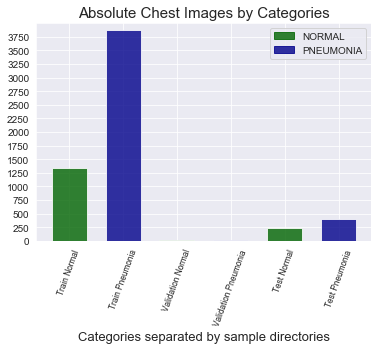

In [18]:
# Visualise all the findings
locations = [0, 1, 2, 3, 4, 5]
colors = ['darkgreen', 'darkblue', 'darkgreen', 'darkblue', 'darkgreen', 'darkblue']
hights = [count_train_normal, count_train_pneumonia, count_valid_normal, count_valid_pneumonia,
         count_test_normal, count_test_pneumonia]
width = 0.65
label_list = ['Train Normal', 'Train Pneumonia', 'Validation Normal', 'Validation Pneumonia',
              'Test Normal', 'Test Pneumonia']
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.yticks(np.arange(0, 4000, 250))
labels = ax.set_xticklabels(label_list, rotation=70, fontsize='small')
plt.bar(locations, hights, width, color=colors, tick_label=labels, alpha=0.8)
plt.ylim([0, 4000])
plt.title('Absolute Chest Images by Categories', fontsize=15)
plt.xlabel('Categories separated by sample directories', fontsize=13)
green_patch = mpatches.Patch(color='darkgreen', label='NORMAL', alpha=0.8)
blue_patch = mpatches.Patch(color='darkblue', label='PNEUMONIA', alpha=0.8)
plt.legend(handles = [green_patch, blue_patch])

**Note:**<br>
In each set there are much more Pneumonia cases compared to the non-Pneumonia ones, especially for the training set. So, there is a kind of inbalance.  ToDo: inform if this is a severe one to take care of ...

In [19]:
# For simpler usage, first we have to put the data in a dictionary.
# {'train' : {'Normal' : count_train_normal,
#             'Pneumonia' : count_train_pneumonia},
#  'valid' : {'Normal' : count_valid_normal,
#             'Pneumonia' : count_valid_pneumonia}, 
#  'test' : {'Normal' : count_test_normal, 
#            'Pneumonia' : count_test_pneumonia}}

categories_counter_data = {"Sample" : ["train", "valid", "test"],
                           "Normal" : [count_train_normal, count_valid_normal, count_test_normal],
                           "Pneumonia" : [count_train_pneumonia, count_valid_pneumonia, count_test_pneumonia]}

df_categories = pd.DataFrame(data = categories_counter_data, index = ["train", "valid", "test"])

In [20]:
# Add the amount difference for each category and directory to the dataframe
df_categories['Difference'] = df_categories['Normal'] - df_categories['Pneumonia']

In [21]:
# Visualise the differences compared to category and sample directories,
# therefore use the absolute values of the differences as well to see them on the same positive level
df_categories['Difference_abs'] = df_categories['Difference'] * (-1)
df_categories.head()

,Sample,Normal,Pneumonia,Difference,Difference_abs
train,train,1341,3875,-2534,2534
valid,valid,8,8,0,0
test,test,234,390,-156,156


Now, the relationship of the amount difference between the normal and pneumonia samples are visualised. Again the validation sets are so small, that they are not realisable in such a bar diagram.

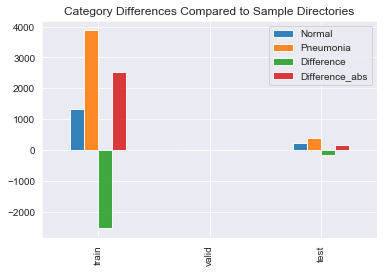

In [22]:
#locations = [0, 1, 2}
x_labels = ['Train', 'Valid', 'Test']

df_categories.plot(title='Category Differences Compared to Sample Directories', kind='bar', tick_label=x_labels, alpha=0.9)

The training set (x label: train) has much more pneumonia cases compared to the normal ones, this is not the case for the testing samples (x label: test) of normal and pneumonia chest images. They look much more balanced. The validation samples (x label: valid) are very small.

**Additional question** regarding the different sample directories: How many of the pneumonia chest images have virus or bacteria as _root cause_?

In [23]:
def get_rootcause_counter(files):
    ''' delivers the amount of bacteria or virus pneumonia images '''
    counter_virus = 0
    counter_bacteria = 0
    file_array = files
    
    
    for item in file_array:
        if 'virus' in item:
            counter_virus += 1
        elif 'bacteria' in item:
            counter_bacteria += 1
        else:
            print('{} does not include a root cause in its file name string (virus or bac.')
            
    return counter_virus, counter_bacteria

count_train_virus, count_train_bacteria = get_rootcause_counter(train_pneumonia_files)
count_valid_virus, count_valid_bacteria = get_rootcause_counter(valid_pneumonia_files)
count_test_virus, count_test_bacteria = get_rootcause_counter(test_pneumonia_files)

print("--- Train pneumonia files ---")        
print("{} virus chest images.".format(count_train_virus))
print("{} bacteria chest images.".format(count_train_bacteria))

print("\n--- Validation pneumonia files ---")        
print("{} virus chest images.".format(count_valid_virus))
print("{} bacteria chest images.".format(count_valid_bacteria))

print("\n--- Test pneumonia files ---")        
print("{} virus chest images.".format(count_test_virus))
print("{} bacteria chest images.".format(count_test_bacteria))

--- Train pneumonia files ---
1345 virus chest images.
2530 bacteria chest images.

--- Validation pneumonia files ---
0 virus chest images.
8 bacteria chest images.

--- Test pneumonia files ---
148 virus chest images.
242 bacteria chest images.


**Note:**<br>
In the future, having more pneumonia chest images with further root causes (not only virus and bacteria root causes exist), the algorithm can be improved doing a multi-class classification between normal and pneumonia ones, where the pneumonia ones are differentiated by their root cause from the scratch.

<a id='step3'></a>
## Step 3: Data Pre-Processing

Keras is using TensorFlow as backend, means as tensor manipulation. According the TensorFlow [guide](https://www.tensorflow.org/guide/tensors), a "tensor is a generalization of vectors and matrices to potentially higher dimensions. Internally, TensorFlow represents tensors as n-dimensional arrays of base datatypes." 

Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  


The `path_to_tensor` function below takes a string-valued file path to a grey-scale chest image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with grey-scale images, each image has one [channel](https://www.tensorflow.org/api_docs/python/tf/summary/image).  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 1).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 1).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset.

In [24]:
def path_to_tensor(img_path):
    # loads grey-scale image as PIL.Image.Image type
    img = load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 1)
    x = img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 1) and return 4D tensor
    
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

We rescale the images by dividing every pixel in every image by 255.

In [25]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████| 624/624 [01:07<00:00,  9.26it/s]


In [26]:
print('The tensor shape of the images is:')
print('Train dataset shape: {}'.format(train_tensors.shape))
print('Validation dataset shape: {}'.format(valid_tensors.shape))
print('Test dataset shape: {}'.format(test_tensors.shape))

The tensor shape of the images is:
Train dataset shape: (5216, 224, 224, 3)
Validation dataset shape: (16, 224, 224, 3)
Test dataset shape: (624, 224, 224, 3)


<a id='step4'></a>
## Step 4: Create a CNN Model from the Scratch (Basic Model)

### Model Implementation

Start creating a basic model with 5 blocks of Convolutional, MaxPooling and Dropout sublayers as hidden layer components. As flatten layer GlobalAveragePooling2D is used. The output Dense layer for the 2 resulting categories NORMAL and PNEUMONIA is using 'softmax' as activation function.

In [27]:
# Define the base model architecture.
# Start with the basic model
base_model_class = Model("Basic", "Basic_CNN_Model", "accuracy")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

--- Build model summary of Basic_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
______________________________________

### Compile the Model

As optimiser 'rmsprop' with loss function 'binary_crossentropy' and 'accuracy' metric is used. The weights of the model layers will be updated during training.

In [28]:
base_model_class = base_model_class.get_class()
# Is it the expected class?
base_model_class

In [29]:
# use with general optimiser 'rmsprop'
base_model = base_model_class.get_model()
base_model_class.compile_model(model=base_model, optimizer='rmsprop',
                               loss='binary_crossentropy', metrics=['accuracy'])

### Train the Model

Model training with use of checkpointing to save the model that attains the best validation loss. The following hyperparameters are set: 
- `epochs` is set to a number of iterations including the point where the network stops learning or start overfitting
- `batch_size` is set to a common minimal size of memory: 32; if your machine is better use 64, 128, 256, ... 

For the original dataset: train on 5216 samples, therefore batch_size=32 => 5216/32 = 163<br>
For the modified dataset: e.g. train on 134 x 32 = 4288 samples  (same batch size of 32)

In [30]:
# specify the number of epochs used to train the model

# regarding the original dataset: 
# train on 5216 samples, therefore batch_size=32 => 5216/32 = 163

base_model_history = base_model_class.train_model(model=base_model, epochs=20, batch_size=32,
                                           filepath='./saved_models/base_model_weights.best.from_scratch.hdf5',
                                           train_tensors=train_tensors, train_targets=train_targets,
                                           valid_tensors=valid_tensors, valid_targets=valid_targets)

Instructions for updating:
Use tf.cast instead.
Train on 5216 samples, validate on 16 samples
Epoch 1/15
 - 1684s - loss: 3.9938 - acc: 0.7280 - val_loss: 5.9475 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 5.94746, saving model to ./saved_models/base_model_weights.best.from_scratch.hdf5
Epoch 2/15
 - 1667s - loss: 4.1213 - acc: 0.7429 - val_loss: 6.2197 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 5.94746
Epoch 3/15
 - 1672s - loss: 4.1213 - acc: 0.7429 - val_loss: 6.6683 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 5.94746
Epoch 4/15
 - 1666s - loss: 4.1213 - acc: 0.7429 - val_loss: 6.9261 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 5.94746
Epoch 5/15
 - 1660s - loss: 4.1213 - acc: 0.7429 - val_loss: 6.9261 - val_acc: 0.5000

Epoch 00005: val_loss did not improve from 5.94746
Epoch 6/15
 - 1611s - loss: 4.1213 - acc: 0.7429 - val_loss: 6.9261 - val_acc: 0.5000

Epoch 00006: val_loss did not improve from 5.94746
Epoc

**Note:**<br>
As visible on all results, the model shows high overfitting and cannot be used for the given task. Would this change by using this model architecture with the augmentation concept?

<a id='step5'></a>
## Step 5 Last Basic Model with Augmentation

### Model Implementation and Training

We are using image data augmentation to decrease the amount of images of our training dataset, and see if there is an improvement to reduce the existing misclassification error. This concept shall improve the performance and the generalisation ability of our network. We want to prevent overfitting. Keras offers already a process to do this, using its ImageDataGenerator object class. The original images are rotated, shifted, zoomed, flipped etc. and by doing this, creating new image mutations. So, the range of images for each epoch increases and the propability that the algorithm sees the same images more than once is much reduced.

Generator handling according the given Keras example using .flow() functionality together with the already created pre-processed tensors instances. With such tensors rescaling by /255 has already happened. The .flow() command generates batches of randomly transformed images.

The generator parameters are set according the image properties, having chest images. E.g. huge zooming or rotation would make no sense, but horizontal flip is fine. 

In general according augmentation information, have a look to the associated Keras classification [article](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

In [32]:
train_data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    rescale=1.,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest')

validation_generator = ImageDataGenerator(rescale=1)

In [33]:
batch_size = 32
training_data = train_data_generator.flow(train_tensors, train_targets, batch_size=batch_size)
validation_data = validation_generator.flow(valid_tensors, valid_targets, batch_size=batch_size)

In [34]:
model = Model("Basic", "Basic_CNN_Model", "accuracy")
aug_base_model_class = model.get_class()


--- Build model summary of Basic_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)          

In [37]:
aug_base_model = aug_base_model_class.get_model()
aug_base_model_class.compile_model(model=aug_base_model, optimizer='rmsprop',
                                   loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
epochs = 20  # first try
aug_base_model_history = aug_base_model_class.augmentation_train_model(model=aug_base_model,
                                  filepath='./saved_models/base_model_weights.best.withAugmentation.hdf5',
                                  training_data=training_data, validation_data=validation_data,
                                  epochs=epochs, batch_size=batch_size,
                                  train_tensors=train_tensors, valid_tensors=valid_tensors)

Epoch 1/15
 - 993s - loss: 3.6156 - acc: 0.7744 - val_loss: 4.0057 - val_acc: 0.6892

Epoch 00001: val_loss improved from inf to 4.00565, saving model to ./saved_models/base_model_weights.best.withAugmentation.hdf5
Epoch 2/15
 - 996s - loss: 3.5958 - acc: 0.7757 - val_loss: 3.8498 - val_acc: 0.7024

Epoch 00002: val_loss improved from 4.00565 to 3.84985, saving model to ./saved_models/base_model_weights.best.withAugmentation.hdf5
Epoch 3/15
 - 998s - loss: 3.5987 - acc: 0.7755 - val_loss: 4.1857 - val_acc: 0.6743

Epoch 00003: val_loss did not improve from 3.84985
Epoch 4/15
 - 1043s - loss: 3.6556 - acc: 0.7720 - val_loss: 3.8772 - val_acc: 0.6997

Epoch 00004: val_loss did not improve from 3.84985
Epoch 5/15
 - 1062s - loss: 3.5513 - acc: 0.7785 - val_loss: 3.9260 - val_acc: 0.6936

Epoch 00005: val_loss did not improve from 3.84985
Epoch 6/15
 - 1054s - loss: 3.5982 - acc: 0.7755 - val_loss: 4.1103 - val_acc: 0.6813

Epoch 00006: val_loss did not improve from 3.84985
Epoch 7/15
 - 9

<a id='step6'></a>
## Step 6: Such Basic Model with Adam as Optimiser

### Compile and Train the Model

In [48]:
# Start creating as new instance with the basic model
model = Model("Basic", "Basic_CNN_Model", "accuracy")
adam_base_model_class = model.get_class()
adam_base_model = adam_base_model_class.get_model()
adam_base_model  # must be Sequential instance


--- Build model summary of Basic_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)         

In [49]:
# adam defaults:
# keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# learn with decay to avoid overfitting, decay=1e-6
adam_base_model_class.set_Adam_params()
adam_base_model_class.compile_model(model=adam_base_model, optimizer='Adam', loss='binary_crossentropy',
                                    metrics=['accuracy'])
adam_base_model = adam_base_model_class.get_model()

In [50]:
# train the model with call of train function
adam_base_model_history = adam_base_model_class.train_model(model=adam_base_model, epochs=20, batch_size = 32,
                                  filepath='./saved_models/base_model_weights_withAdam.best.from_scratch.hdf5',
                                  train_tensors=train_tensors, train_targets=train_targets,
                                  valid_tensors=valid_tensors, valid_targets=valid_targets)

Train on 3517 samples, validate on 1171 samples
Epoch 1/15
 - 973s - loss: 0.5142 - acc: 0.7748 - val_loss: 0.4452 - val_acc: 0.6900

Epoch 00001: val_loss improved from inf to 0.44520, saving model to ./saved_models/base_model_weights_withAdam.best.from_scratch.hdf5
Epoch 2/15
 - 997s - loss: 0.3619 - acc: 0.8155 - val_loss: 0.4427 - val_acc: 0.7079

Epoch 00002: val_loss improved from 0.44520 to 0.44272, saving model to ./saved_models/base_model_weights_withAdam.best.from_scratch.hdf5
Epoch 3/15
 - 958s - loss: 0.3386 - acc: 0.8311 - val_loss: 0.4175 - val_acc: 0.7822

Epoch 00003: val_loss improved from 0.44272 to 0.41751, saving model to ./saved_models/base_model_weights_withAdam.best.from_scratch.hdf5
Epoch 4/15
 - 913s - loss: 0.3194 - acc: 0.8433 - val_loss: 0.4227 - val_acc: 0.7703

Epoch 00004: val_loss did not improve from 0.41751
Epoch 5/15
 - 894s - loss: 0.3077 - acc: 0.8513 - val_loss: 0.3560 - val_acc: 0.8488

Epoch 00005: val_loss improved from 0.41751 to 0.35595, savin

<a id='step7'></a>
## Step 7: Last Basic Model with Adam and Augmentation

### Model Implementation and Training

In [59]:
# create new instance
model = Model("Basic", "Basic_CNN_Model", "accuracy")
adam_aug_base_model_class = model.get_class()
adam_aug_base_model = adam_aug_base_model_class.get_model()


--- Build model summary of Basic_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)         

In [61]:
adam_aug_base_model_class.set_Adam_params()
adam_aug_base_model_class.compile_model(model=adam_aug_base_model, optimizer='Adam', loss='binary_crossentropy',
                                    metrics=['accuracy'])
adam_aug_base_model = adam_aug_base_model_class.get_model()

In [62]:
epochs = 20
#  still the same: batch_size = 32

# use the same generator instance and flow data as before ...
# valid_tensors.shape[0] -> original dataset: 16 / 32 = 0.5
adam_aug_base_model_history = adam_aug_base_model_class.augmentation_train_model(model=adam_aug_base_model,
                                  filepath='./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5',
                                  training_data=training_data, validation_data=validation_data,
                                  epochs=epochs, batch_size=batch_size,
                                  train_tensors=train_tensors, valid_tensors=valid_tensors)

Epoch 1/15
 - 955s - loss: 0.5346 - acc: 0.7767 - val_loss: 0.6275 - val_acc: 0.6769

Epoch 00001: val_loss improved from inf to 0.62753, saving model to ./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5
Epoch 2/15
 - 991s - loss: 0.4364 - acc: 0.7779 - val_loss: 0.6257 - val_acc: 0.6997

Epoch 00002: val_loss improved from 0.62753 to 0.62568, saving model to ./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5
Epoch 3/15
 - 905s - loss: 0.3834 - acc: 0.7986 - val_loss: 0.5601 - val_acc: 0.7217

Epoch 00003: val_loss improved from 0.62568 to 0.56013, saving model to ./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5
Epoch 4/15
 - 903s - loss: 0.3779 - acc: 0.8023 - val_loss: 0.5000 - val_acc: 0.7691

Epoch 00004: val_loss improved from 0.56013 to 0.49997, saving model to ./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5
Epoch 5/15
 - 848s - loss: 0.3367 - acc: 0.8304 - val_loss: 0.4329 - val_acc: 0.8218

Epoch 00005: val_loss 

<a id='step8'></a>
## Step 8: Create an improved CNN Model with Adam

Now, we train a model having more hidden layers - a more complex architecture - using Adam as optimiser at once, what kind of result will be calculated compared to the last basic model after having done the augmentation improvement? The Adam optimiser is used for learning with binary crossentropy loss function.

Afterwards, we apply the augmentation concept on this improved model and see what kind of performance difference will appear.

To know more about improved model architectures the following [paper](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf) is available:
'Going Deeper with Convolutions'


### Model Implementation

In [73]:
# Define the improved model architecture.
improved_model = Model("Improved", "Improved_CNN_Model", "accuracy")
improved_model_class = improved_model.get_class()


--- Build model summary of Improved_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 111, 111, 32)      4128      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_27 (Dropout)    

### Compile the Model

In [74]:
# first try: use Adam optimiser with same decay as basic model, decay=1e-6 
improved_model = improved_model_class.get_model()
improved_model_class.set_Adam_params()
improved_model_class.compile_model(model=improved_model, optimizer='Adam', loss='binary_crossentropy',
                                   metrics=['accuracy'])

### Train the Model

In [75]:
epochs = 20
batch_size = 32
improved_model_adam = improved_model_class.get_model()
improved_model_history = improved_model_class.train_model(model=improved_model_adam,
                                           epochs=epochs, batch_size=batch_size,
                                           filepath='./saved_models/improved_model_weights.best.withAdam.hdf5',
                                           train_tensors=train_tensors, train_targets=train_targets,
                                           valid_tensors=valid_tensors, valid_targets=valid_targets)

Train on 3517 samples, validate on 1171 samples
Epoch 1/15
 - 2078s - loss: 3.5551 - acc: 0.7643 - val_loss: 4.9555 - val_acc: 0.6909

Epoch 00001: val_loss improved from inf to 4.95555, saving model to ./saved_models/improved_model_weights.best.withAdam.hdf5
Epoch 2/15
 - 1799s - loss: 3.6099 - acc: 0.7748 - val_loss: 4.9555 - val_acc: 0.6909

Epoch 00002: val_loss did not improve from 4.95555
Epoch 3/15
 - 1904s - loss: 3.6099 - acc: 0.7748 - val_loss: 4.9555 - val_acc: 0.6909

Epoch 00003: val_loss did not improve from 4.95555
Epoch 4/15
 - 1994s - loss: 3.6099 - acc: 0.7748 - val_loss: 4.9555 - val_acc: 0.6909

Epoch 00004: val_loss did not improve from 4.95555
Epoch 5/15
 - 1922s - loss: 3.6099 - acc: 0.7748 - val_loss: 4.9555 - val_acc: 0.6909

Epoch 00005: val_loss did not improve from 4.95555
Epoch 6/15
 - 1851s - loss: 3.6099 - acc: 0.7748 - val_loss: 4.9555 - val_acc: 0.6909

Epoch 00006: val_loss did not improve from 4.95555
Epoch 7/15
 - 1689s - loss: 3.6099 - acc: 0.7748 -

In [77]:
# plot the improved model to a file and store it for further usage (only first time)
#plot_model(improved_model_adam, to_file='./saved_models/improved_model_withAdam.png')

<a id='step9'></a>
## Step 9:  Last improved CNN Model with Augmentation

We use the same ImageDataGenerator instance and flow function results as before.

In [85]:
# new instance learning on the same dataset with augmentation
improved_model_aug = Model("Improved", "Improved_CNN_Model", "accuracy")
improved_model_aug_class = improved_model_aug.get_class()


--- Build model summary of Improved_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 111, 111, 32)      4128      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_33 (Dropout)    

### Compile the Model

In [86]:
improved_model_aug = improved_model_aug_class.get_model()
improved_model_aug_class.set_Adam_params()
improved_model_aug_class.compile_model(model=improved_model_aug, optimizer='Adam', loss='binary_crossentropy',
                                   metrics=['accuracy'])

### Training with Augmentation

In [87]:
epochs = 20
batch_size = 32
# generator and generator flow data, training and validation data are the same as before
improved_model_aug_history = improved_model_aug_class.augmentation_train_model(model=improved_model_aug,
                                filepath='./saved_models/improved_model_weights.best.withAugmentation.hdf5', 
                                training_data=training_data, validation_data=validation_data,
                                epochs=epochs, batch_size=batch_size,
                                train_tensors=train_tensors, valid_tensors=valid_tensors)

Epoch 1/15
 - 1836s - loss: 3.3513 - acc: 0.7701 - val_loss: 4.9400 - val_acc: 0.6918

Epoch 00001: val_loss improved from inf to 4.93996, saving model to ./saved_models/improved_model_weights.best.withAugmentation.hdf5
Epoch 2/15
 - 1828s - loss: 3.6336 - acc: 0.7733 - val_loss: 4.9259 - val_acc: 0.6927

Epoch 00002: val_loss improved from 4.93996 to 4.92589, saving model to ./saved_models/improved_model_weights.best.withAugmentation.hdf5
Epoch 3/15
 - 1769s - loss: 3.6077 - acc: 0.7749 - val_loss: 4.9677 - val_acc: 0.6901

Epoch 00003: val_loss did not improve from 4.92589
Epoch 4/15
 - 1801s - loss: 3.6294 - acc: 0.7736 - val_loss: 4.9259 - val_acc: 0.6927

Epoch 00004: val_loss improved from 4.92589 to 4.92589, saving model to ./saved_models/improved_model_weights.best.withAugmentation.hdf5
Epoch 5/15
 - 1749s - loss: 3.6193 - acc: 0.7742 - val_loss: 5.0526 - val_acc: 0.6848

Epoch 00005: val_loss did not improve from 4.92589
Epoch 6/15
 - 1823s - loss: 3.6087 - acc: 0.7749 - val_l

<a id='step10'></a>
## Step 10: Create a ResNet CNN Model with Transfer Learning

As sense of transfer learning, Goodfellow et al mentioned in their 'Deep Learning' book "Situation where what has been learned in one setting is exploited to improve generalization in another setting."

We don't have a huge dataset for the given pneumonia classification and more generalised, even not for all human age and X-ray orientation categories. The existing dataset is a specific one for a specific task, therefore we need technical help to improve the classification performance having a good, proper learning result, especially thinking at the 'new, available' image examples of the future.

With a pre-trained model, we use its knowledge even from another domain and task (like for image tasks a pre-trained model from the huge ImageNet database including a lot of different object categories), to let our network learn the new problem. This knowledge transfer is possible, because all images share some same features, like e.g. edges, shapes, zooming or rotation. The common features are learned in the hidden layers from the beginning, the more specific task ones are learned at the end of the hidden layer block. To improve our specific classification task we can change the network there and let the first part as learned with the ImageNet database. We don't need our network to learn from scratch. We can freeze such hidden-layer convolutional subblocks and its outputs are the input of the specific classifier block at the end of the network.

Technically, how to do this is e.g. explained in the Keras [documentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).


### Model Implementation and Compilation

First, we create a pre-trained ResNet50 CNN model and freeze the convolution blocks, so that we can use it as an image feature extractor to get the bottleneck features. ResNet is a short name for residual network. It includes a lot of subblocks with BatchNormalization layers.

In [96]:
resNet_model = Model("Transfer", "Transfer_RestNet_CNN_Model", "accuracy")
resNet_model_class = resNet_model.get_class()
input_shape = (224, 224, 3) # see info after tensor creation above
resNet_model_class.build_model_feature_extractor(input_shape=input_shape)

C:\anaconda\anaconda3\envs\chest-class-project-local\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '



--- Build model summary of RestNet Transfer_CNN_Model as feature extractor: ---
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________

res3d_branch2c (Conv2D)         (None, 28, 28, 512)  66048       activation_21[0][0]              
__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 28, 28, 512)  2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_7 (Add)                     (None, 28, 28, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 28, 28, 512)  0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 14, 14, 256)  131328      activation_22[0][0]              
__________

res5b_branch2a (Conv2D)         (None, 7, 7, 512)    1049088     activation_43[0][0]              
__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_44[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation

In [99]:
# plot the transfer model to a file and store it for further usage
resNet_model = resNet_model_class.get_model()

# plotting only first time
#plot_model(resNet_model, to_file='./saved_models/resNet_transfer_model_withoutTopLayer.png')

In [98]:
# print the status
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in resNet_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x0000005BA8771EB8>,input_1,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x0000005BA8771438>,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0x0000005BA87714A8>,conv1,False
3,<keras.layers.normalization.BatchNormalization object at 0x0000005BA877A048>,bn_conv1,False
4,<keras.layers.core.Activation object at 0x0000005BA8783DA0>,activation_1,False
5,<keras.layers.convolutional.ZeroPadding2D object at 0x0000005BA5CBA828>,pool1_pad,False
6,<keras.layers.pooling.MaxPooling2D object at 0x0000005BA8793898>,max_pooling2d_38,False
7,<keras.layers.convolutional.Conv2D object at 0x0000005B0CD26A20>,res2a_branch2a,False
8,<keras.layers.normalization.BatchNormalization object at 0x0000005BA5925390>,bn2a_branch2a,False
9,<keras.layers.core.Activation object at 0x0000005BA5958BA8>,activation_2,False


The last activation feature map of our ResNet CNN model delivers the bottleneck features. They are the input for the flatten layer and used for our specific, final CNN network layer.

In [20]:
#
# if you create the bottleneck features the first time, we need this function; but
# if they are already created and stored skip this creation part and go to the part after npzfile.close()
#
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

In [101]:
print('--- Create bottleneck features for train tensors images ---')
train_resNet = get_bottleneck_features(resNet_model, train_tensors)
print('--- Create bottleneck features for validation tensors images ---')
valid_resNet = get_bottleneck_features(resNet_model, valid_tensors)
print('--- Create bottleneck features for test tensors images ---')
test_resNet = get_bottleneck_features(resNet_model, test_tensors)

--- Create bottleneck features for train tensors images ---
--- Create bottleneck features for validation tensors images ---
--- Create bottleneck features for test tensors images ---


In [102]:
print('RestNet50 train bottleneck features: {}'.format(train_resNet.shape))
print('RestNet50 validation bottleneck features: {}'.format(valid_resNet.shape))
print('RestNet50 test bottleneck features: {}'.format(test_resNet.shape))

RestNet50 train bottleneck features: (3517, 2048)
RestNet50 validation bottleneck features: (1171, 2048)
RestNet50 test bottleneck features: (1171, 2048)


**Note:**<br>
So, our bottleneck features have a dimension of 1x2048. Our new network architecture is taking this bottleneck vectors as input.

In [103]:
valid_resNet

array([[0.       , 0.       , 0.       , ..., 1.9781269, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.8644891, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.9264548, 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.8622309, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.960201 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.8875729, 0.       ,
        0.       ]], dtype=float32)

In [104]:
# store the bottleneck files
np.savez('./bottleneck_features/chest_ResNet50_features.npz',
         train=train_resNet, valid=valid_resNet, test=test_resNet)

In [105]:
# test about files, dont' forget to close the file instance
npzfile = np.load('./bottleneck_features/chest_ResNet50_features.npz')
npzfile.files

['train', 'valid', 'test']

In [106]:
npzfile['valid']

array([[0.       , 0.       , 0.       , ..., 1.9781269, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.8644891, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.9264548, 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.8622309, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.960201 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.8875729, 0.       ,
        0.       ]], dtype=float32)

In [107]:
npzfile.close()

Now, after having stored the bottleneck features of the train, valid and test tensors, we can build our final CNN architecture, means we add the top layer to the existing ResNet model.

As a top model construction a flatten GlobalAveragePooling2D layer, followed by a BatchNormalization instance and the fully connected Dense layer, which handles the 2 different X-ray chest images categories, are used.

In [108]:
#
# if the bottleneck feature file is already stored and this python project runs again ... 
# use this lines of code to get the bottleneck features for the train, valid and test samples
#
bottleneck_features = np.load('./bottleneck_features/chest_ResNet50_features.npz')
train_resNet = bottleneck_features['train']
valid_resNet = bottleneck_features['valid']
test_resNet = bottleneck_features['test']
bottleneck_features.close()

In [109]:
# build the final CNN architecture with added top layer part
resNet_model_class.build_model(resNet_model)
resNet_model = resNet_model_class.get_model()


--- Build model summary of final RestNet Transfer_CNN_Model with top layer: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 4098      
Total params: 12,290
Trainable params: 8,194
Non-trainable params: 4,096
_________________________________________________________________


In [110]:
# let's train the final transfer learning model using Adam with decay 1e-6 for each learning update and 
# a smaller learning rate to avoid to get stuck in a local minimum and to reduce overfitting
resNet_model_class.set_Adam_params(lr=1e-4)
resNet_model_class.compile_model(model= resNet_model, loss='binary_crossentropy',
                                 optimizer='Adam', metrics=['accuracy'])

### Train the Model

In [111]:
epochs = 300  # fast training compared the previous model ones
batch_size = 32
resNet_model = resNet_model_class.get_model()
resNet_transfer_model_history = resNet_model_class.train_model(model=resNet_model,
                                  filepath='./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5',
                                           train_tensors=train_resNet, train_targets=train_targets,
                                           valid_tensors=valid_resNet, valid_targets=valid_targets,
                                           epochs=epochs, batch_size=batch_size)

Train on 3517 samples, validate on 1171 samples
Epoch 1/300
 - 85s - loss: 0.5426 - acc: 0.7296 - val_loss: 0.4227 - val_acc: 0.8019

Epoch 00001: val_loss improved from inf to 0.42269, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 2/300
 - 1s - loss: 0.3550 - acc: 0.8388 - val_loss: 0.3643 - val_acc: 0.8198

Epoch 00002: val_loss improved from 0.42269 to 0.36429, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 3/300
 - 1s - loss: 0.3181 - acc: 0.8527 - val_loss: 0.3336 - val_acc: 0.8437

Epoch 00003: val_loss improved from 0.36429 to 0.33364, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 4/300
 - 1s - loss: 0.2926 - acc: 0.8655 - val_loss: 0.3072 - val_acc: 0.8574

Epoch 00004: val_loss improved from 0.33364 to 0.30716, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 5/300
 - 1s - loss: 0.2743 - acc: 0.8814 - val_loss: 0.29

 - 1s - loss: 0.0947 - acc: 0.9673 - val_loss: 0.1118 - val_acc: 0.9633

Epoch 00085: val_loss improved from 0.11226 to 0.11183, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 86/300
 - 2s - loss: 0.0977 - acc: 0.9653 - val_loss: 0.1117 - val_acc: 0.9650

Epoch 00086: val_loss improved from 0.11183 to 0.11172, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 87/300
 - 1s - loss: 0.0972 - acc: 0.9659 - val_loss: 0.1148 - val_acc: 0.9607

Epoch 00087: val_loss did not improve from 0.11172
Epoch 88/300
 - 2s - loss: 0.1009 - acc: 0.9630 - val_loss: 0.1138 - val_acc: 0.9616

Epoch 00088: val_loss did not improve from 0.11172
Epoch 89/300
 - 2s - loss: 0.0980 - acc: 0.9690 - val_loss: 0.1105 - val_acc: 0.9650

Epoch 00089: val_loss improved from 0.11172 to 0.11051, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 90/300
 - 1s - loss: 0.0947 - acc: 0.9682 - val_loss: 0.1121 


Epoch 00135: val_loss did not improve from 0.10140
Epoch 136/300
 - 2s - loss: 0.0857 - acc: 0.9721 - val_loss: 0.1007 - val_acc: 0.9633

Epoch 00136: val_loss improved from 0.10140 to 0.10069, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 137/300
 - 1s - loss: 0.0885 - acc: 0.9653 - val_loss: 0.1017 - val_acc: 0.9624

Epoch 00137: val_loss did not improve from 0.10069
Epoch 138/300
 - 1s - loss: 0.0818 - acc: 0.9693 - val_loss: 0.1001 - val_acc: 0.9650

Epoch 00138: val_loss improved from 0.10069 to 0.10011, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 139/300
 - 2s - loss: 0.0858 - acc: 0.9673 - val_loss: 0.1009 - val_acc: 0.9650

Epoch 00139: val_loss did not improve from 0.10011
Epoch 140/300
 - 1s - loss: 0.0856 - acc: 0.9664 - val_loss: 0.1033 - val_acc: 0.9607

Epoch 00140: val_loss did not improve from 0.10011
Epoch 141/300
 - 2s - loss: 0.0883 - acc: 0.9670 - val_loss: 0.1043 - val_acc: 0.960


Epoch 00243: val_loss did not improve from 0.09185
Epoch 244/300
 - 2s - loss: 0.0730 - acc: 0.9744 - val_loss: 0.0929 - val_acc: 0.9693

Epoch 00244: val_loss did not improve from 0.09185
Epoch 245/300
 - 1s - loss: 0.0735 - acc: 0.9704 - val_loss: 0.0909 - val_acc: 0.9727

Epoch 00245: val_loss improved from 0.09185 to 0.09095, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 246/300
 - 1s - loss: 0.0680 - acc: 0.9750 - val_loss: 0.0954 - val_acc: 0.9650

Epoch 00246: val_loss did not improve from 0.09095
Epoch 247/300
 - 2s - loss: 0.0724 - acc: 0.9730 - val_loss: 0.0924 - val_acc: 0.9701

Epoch 00247: val_loss did not improve from 0.09095
Epoch 248/300
 - 2s - loss: 0.0714 - acc: 0.9733 - val_loss: 0.0922 - val_acc: 0.9701

Epoch 00248: val_loss did not improve from 0.09095
Epoch 249/300
 - 1s - loss: 0.0737 - acc: 0.9758 - val_loss: 0.0930 - val_acc: 0.9684

Epoch 00249: val_loss did not improve from 0.09095
Epoch 250/300
 - 2s - loss: 0.075

In [113]:
# plot the top layer of the transfer model to a file and store it for further usage (only first time)
#plot_model(resNet_model, to_file='./saved_models/resNet_transfer_model_topLayer.png')

<a id='step11'></a>
## Step 11: Fine-tuned Transfer Learning ResNet CNN Model with Augmentation

Now, we unfreeze the last res5c layer block of the formerly created transfer learning CNN model build architecture. There, the layer weights will be updated in each epoch as we pass the data batch. The training is implemented to use the augmentation concept with generators as before.

In [8]:
resNet_model = Model("Transfer", "Transfer_ResNet_CNN_Model", "accuracy")
resNet_ft_model_class = resNet_model.get_class()
input_shape = (224, 224, 3) # see info after tensor creation above
resNet_ft_model = resNet_ft_model_class.build_finetuned_model(input_shape=input_shape)

Instructions for updating:
Colocations handled automatically by placer.


C:\anaconda\anaconda3\envs\chest-class-project-local\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '



--- Build model summary of fine-tuned RestNet Transfer_CNN_Model: ---
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
______________________________________

__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 28, 28, 512)  2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_7 (Add)                     (None, 28, 28, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 28, 28, 512)  0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 14, 14, 256)  131328      activation_22[0][0]              
__________________________________________________________________________________________________
bn4a_branc

__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_44[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2b[0][0]              
__________

In [9]:
# print the status        
layers = [(layer, layer.name, layer.trainable) for layer in resNet_ft_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,False
1,<keras.layers.convolutional.ZeroPadding2D obje...,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0...,conv1,False
3,<keras.layers.normalization.BatchNormalization...,bn_conv1,False
4,<keras.layers.core.Activation object at 0x0000...,activation_1,False
5,<keras.layers.convolutional.ZeroPadding2D obje...,pool1_pad,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,max_pooling2d_1,False
7,<keras.layers.convolutional.Conv2D object at 0...,res2a_branch2a,False
8,<keras.layers.normalization.BatchNormalization...,bn2a_branch2a,False
9,<keras.layers.core.Activation object at 0x0000...,activation_2,False


### Compile and Train the Model

In [10]:
resNet_model_class.build_ResNet_aug_model(resNet_ft_model)
resNet_ft_model = resNet_model_class.get_model()
resNet_model_class.set_Adam_params(lr=1e-4)
resNet_model_class.compile_model(model= resNet_ft_model, loss='binary_crossentropy',
                                 optimizer='Adam', metrics=['accuracy'])


--- Build model summary of augmented RestNet Transfer_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 2048)              23587712  
_________________________________________________________________
input_2 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,600,002
Trainable params: 4,473,858
Non-trainable params: 19,126,144
_________________________________________________________________


In [18]:
epochs = 20  # very slow training
batch_size = 32
# generator and generator flow data, training and validation data are the same as before;
# because of augmentation concept, bottleneck features are not used

resNet_finetuned_model_aug_history = resNet_ft_model_class.augmentation_train_model(model=resNet_ft_model,
               filepath='./saved_models/transfer_ResNet50_finetuned_model_weights.best.withAugmentation.hdf5', 
                                training_data=training_data, validation_data=validation_data,
                                epochs=epochs, batch_size=batch_size,
                                train_tensors=train_tensors,
                                valid_tensors=valid_tensors)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
 - 12400s - loss: 0.3351 - acc: 0.8813 - val_loss: 1.0173 - val_acc: 0.3108

Epoch 00001: val_loss improved from inf to 1.01731, saving model to ./saved_models/transfer_ResNet50_finetuned_model_weights.best.withAugmentation.hdf5
Epoch 2/15
 - 13383s - loss: 0.1660 - acc: 0.9558 - val_loss: 0.6286 - val_acc: 0.6962

Epoch 00002: val_loss improved from 1.01731 to 0.62855, saving model to ./saved_models/transfer_ResNet50_finetuned_model_weights.best.withAugmentation.hdf5
Epoch 3/15
 - 13464s - loss: 0.1482 - acc: 0.9552 - val_loss: 0.6572 - val_acc: 0.6874

Epoch 00003: val_loss did not improve from 0.62855
Epoch 4/15
 - 12913s - loss: 0.1260 - acc: 0.9656 - val_loss: 0.6545 - val_acc: 0.6892

Epoch 00004: val_loss did not improve from 0.62855
Epoch 5/15
 - 14802s - loss: 0.0867 - acc: 0.9704 - val_loss: 0.6843 - val_acc: 0.6901

Epoch 00005: val_loss did not improve from 0.62855
Epoch 6/15
 - 16169s - loss: 0.0870 - acc: 0.9716 -

<a id='step12'></a>
## Step 12: Create an InceptionV3 CNN Model with Transfer Learning

Keras InceptionV3 model is one of the models to classify images. It has already been trained on the huge image database ImageNet, therefore optimized filter weights ('bottleneck features') are available for input usage of a top model layer. The concept of the inception module focuses on the kernel size of convolutional layers (https://arxiv.org/pdf/1409.4842.pdf). This concept is much better according test accuracy compared with the results of the creation of a model architecture from the scratch as at the beginning of this project. There no pre-trained information is available.<br>
For this project the transfer learning concept has been chosen on an InceptionV3 CNN instance as basic architecture together with its bottleneck features. As a top model construction a flatten GlobalAveragePooling2D layer, followed by a BatchNormalization instance and the fully connected Dense layer, which handles the 2 different chest categories.

### Model Implementation and Compilation

Again, we create a pre-trained InceptionV3 CNN model and freeze the convolution blocks, so that we can use it as an image feature extractor to get the bottleneck features.

In [21]:
inception_model = Model("Transfer", "Transfer_InceptionV3_CNN_Model", "accuracy")
inception_model_class = inception_model.get_class()
input_shape = (224, 224, 3) # see info after tensor creation above
inception_model_class.build_model_feature_extractor(input_shape=input_shape)

Instructions for updating:
Colocations handled automatically by placer.

--- Build model summary of InceptionV3 Transfer_CNN_Model as feature extractor: ---
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32

__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 25, 25, 96)   82944       activation_24[0][0]              
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 25, 25, 64)   18432       average_pooling2d_3[0][0]        
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 25, 25, 64)   192         conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 25, 25, 64)   192         conv2d_22[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 25, 25, 96)   288         conv2d_25[0][0]                  
__________

__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 12, 12, 192)  215040      activation_48[0][0]              
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 12, 12, 192)  147456      average_pooling2d_5[0][0]        
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 12, 12, 192)  576         conv2d_41[0][0]                  
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 12, 12, 192)  576         conv2d_44[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 12, 12, 192)  576         conv2d_49[0][0]                  
__________

activation_73 (Activation)      (None, 12, 12, 192)  0           batch_normalization_73[0][0]     
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 12, 12, 192)  258048      activation_73[0][0]              
__________________________________________________________________________________________________
batch_normalization_74 (BatchNo (None, 12, 12, 192)  576         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_74 (Activation)      (None, 12, 12, 192)  0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 12, 12, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_75 

__________________________________________________________________________________________________
activation_94 (Activation)      (None, 5, 5, 192)    0           batch_normalization_94[0][0]     
__________________________________________________________________________________________________
mixed10 (Concatenate)           (None, 5, 5, 2048)   0           activation_86[0][0]              
                                                                 mixed9_1[0][0]                   
                                                                 concatenate_2[0][0]              
                                                                 activation_94[0][0]              
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           mixed10[0][0]                    
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_______________________________

In [22]:
# plot the transfer model to a file and store it for further usage
inception_model = inception_model_class.get_model()

# plotting the model only first time
#plot_model(inception_model, to_file='./saved_models/inception_transfer_model_withoutTopLayer.png')

In [23]:
# print the status
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in inception_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000000BDB703D160>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x000000BD9FA435C0>,conv2d_1,False
2,<keras.layers.normalization.BatchNormalization object at 0x000000BD9FA434E0>,batch_normalization_1,False
3,<keras.layers.core.Activation object at 0x000000BD9FA43828>,activation_1,False
4,<keras.layers.convolutional.Conv2D object at 0x000000BD89E5F9E8>,conv2d_2,False
5,<keras.layers.normalization.BatchNormalization object at 0x000000BDB71DC588>,batch_normalization_2,False
6,<keras.layers.core.Activation object at 0x000000BDB71FE4E0>,activation_2,False
7,<keras.layers.convolutional.Conv2D object at 0x000000BD9FB20828>,conv2d_3,False
8,<keras.layers.normalization.BatchNormalization object at 0x000000BD9FBB6B70>,batch_normalization_3,False
9,<keras.layers.core.Activation object at 0x000000BD9FB817B8>,activation_3,False


In [25]:
# bottleneck feature function is already defined above
print('--- Create bottleneck features for train tensors images ---')
train_inception = get_bottleneck_features(inception_model, train_tensors)
print('--- Create bottleneck features for validation tensors images ---')
valid_inception = get_bottleneck_features(inception_model, valid_tensors)
print('--- Create bottleneck features for test tensors images ---')
test_inception = get_bottleneck_features(inception_model, test_tensors)

--- Create bottleneck features for train tensors images ---
--- Create bottleneck features for validation tensors images ---
--- Create bottleneck features for test tensors images ---


In [26]:
# store the bottleneck files
np.savez('./bottleneck_features/chest_InceptionV3_features.npz',
         train=train_inception, valid=valid_inception, test=test_inception)

In [27]:
# test about files, dont' forget to close the file instance
npzfile = np.load('./bottleneck_features/chest_InceptionV3_features.npz')
npzfile.files

['train', 'valid', 'test']

In [28]:
npzfile['valid']

array([[0.37495032, 0.32061154, 0.09277023, ..., 0.8561453 , 0.42200717,
        0.5565823 ],
       [0.522304  , 0.11828761, 0.4461374 , ..., 0.43189692, 0.38857147,
        1.4887803 ],
       [0.2870074 , 0.01787213, 0.54951084, ..., 0.9823453 , 0.0705673 ,
        0.41341886],
       ...,
       [0.18315914, 0.00623136, 0.0066017 , ..., 1.0730983 , 0.        ,
        1.0876442 ],
       [0.11652835, 0.12016542, 0.        , ..., 0.1641608 , 0.00387593,
        0.58094   ],
       [0.24596393, 0.09355435, 0.3180822 , ..., 1.2017455 , 0.08988428,
        0.5283393 ]], dtype=float32)

In [29]:
npzfile.close()

In [24]:
#
# if the bottleneck feature file is already stored and this python project runs again ... 
# use this lines of code to get the bottleneck features for the train, valid and test samples
#
bottleneck_features = np.load('./bottleneck_features/chest_InceptionV3_features.npz')
train_inception = bottleneck_features['train']
valid_inception = bottleneck_features['valid']
test_inception = bottleneck_features['test']
bottleneck_features.close()

In [25]:
# build the final CNN architecture with added top layer part
inception_model_class.build_model(inception_model)
inception_model = inception_model_class.get_model()


--- Build model summary of final RestNet Transfer_CNN_Model with top layer: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_95 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 12,290
Trainable params: 8,194
Non-trainable params: 4,096
_________________________________________________________________


In [26]:
# let's train the final transfer learning model using Adam with decay 1e-6 for each learning update and 
# a smaller learning rate to avoid to get stuck in a local minimum and to reduce overfitting
inception_model_class.set_Adam_params(lr=1e-4)
inception_model_class.compile_model(model= inception_model, loss='binary_crossentropy',
                                 optimizer='Adam', metrics=['accuracy'])

### Train the Model

In [27]:
epochs = 300  # fast training compared the previous ones
batch_size = 32
inception_model = inception_model_class.get_model()
inception_transfer_model_history = inception_model_class.train_model(model=inception_model,
                               filepath='./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5',
                                           train_tensors=train_inception, train_targets=train_targets,
                                           valid_tensors=valid_inception, valid_targets=valid_targets,
                                           epochs=epochs, batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Train on 3517 samples, validate on 1171 samples
Epoch 1/300
 - 8s - loss: 0.6278 - acc: 0.6989 - val_loss: 0.4010 - val_acc: 0.8241

Epoch 00001: val_loss improved from inf to 0.40103, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 2/300
 - 1s - loss: 0.3155 - acc: 0.8740 - val_loss: 0.2739 - val_acc: 0.8941

Epoch 00002: val_loss improved from 0.40103 to 0.27389, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 3/300
 - 1s - loss: 0.2303 - acc: 0.9133 - val_loss: 0.2165 - val_acc: 0.9120

Epoch 00003: val_loss improved from 0.27389 to 0.21652, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 4/300
 - 1s - loss: 0.1834 - acc: 0.9343 - val_loss: 0.1866 - val_acc: 0.9266

Epoch 00004: val_loss improved from 0.21652 to 0.18656, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoc


Epoch 00098: val_loss did not improve from 0.10351
Epoch 99/300
 - 1s - loss: 0.0266 - acc: 0.9935 - val_loss: 0.1109 - val_acc: 0.9564

Epoch 00099: val_loss did not improve from 0.10351
Epoch 100/300
 - 1s - loss: 0.0305 - acc: 0.9918 - val_loss: 0.1088 - val_acc: 0.9599

Epoch 00100: val_loss did not improve from 0.10351
Epoch 101/300
 - 1s - loss: 0.0287 - acc: 0.9909 - val_loss: 0.1111 - val_acc: 0.9573

Epoch 00101: val_loss did not improve from 0.10351
Epoch 102/300
 - 1s - loss: 0.0277 - acc: 0.9915 - val_loss: 0.1124 - val_acc: 0.9556

Epoch 00102: val_loss did not improve from 0.10351
Epoch 103/300
 - 1s - loss: 0.0257 - acc: 0.9929 - val_loss: 0.1102 - val_acc: 0.9573

Epoch 00103: val_loss did not improve from 0.10351
Epoch 104/300
 - 2s - loss: 0.0276 - acc: 0.9926 - val_loss: 0.1096 - val_acc: 0.9599

Epoch 00104: val_loss did not improve from 0.10351
Epoch 105/300
 - 1s - loss: 0.0272 - acc: 0.9932 - val_loss: 0.1102 - val_acc: 0.9564

Epoch 00105: val_loss did not impr

Epoch 158/300
 - 1s - loss: 0.0175 - acc: 0.9966 - val_loss: 0.1194 - val_acc: 0.9530

Epoch 00158: val_loss did not improve from 0.10351
Epoch 159/300
 - 1s - loss: 0.0193 - acc: 0.9952 - val_loss: 0.1182 - val_acc: 0.9547

Epoch 00159: val_loss did not improve from 0.10351
Epoch 160/300
 - 2s - loss: 0.0159 - acc: 0.9966 - val_loss: 0.1188 - val_acc: 0.9547

Epoch 00160: val_loss did not improve from 0.10351
Epoch 161/300
 - 1s - loss: 0.0225 - acc: 0.9940 - val_loss: 0.1167 - val_acc: 0.9539

Epoch 00161: val_loss did not improve from 0.10351
Epoch 162/300
 - 1s - loss: 0.0185 - acc: 0.9949 - val_loss: 0.1181 - val_acc: 0.9547

Epoch 00162: val_loss did not improve from 0.10351
Epoch 163/300
 - 1s - loss: 0.0191 - acc: 0.9949 - val_loss: 0.1157 - val_acc: 0.9564

Epoch 00163: val_loss did not improve from 0.10351
Epoch 164/300
 - 1s - loss: 0.0160 - acc: 0.9966 - val_loss: 0.1165 - val_acc: 0.9590

Epoch 00164: val_loss did not improve from 0.10351
Epoch 165/300
 - 1s - loss: 0.0185


Epoch 00217: val_loss did not improve from 0.10351
Epoch 218/300
 - 1s - loss: 0.0139 - acc: 0.9977 - val_loss: 0.1292 - val_acc: 0.9522

Epoch 00218: val_loss did not improve from 0.10351
Epoch 219/300
 - 1s - loss: 0.0104 - acc: 0.9983 - val_loss: 0.1252 - val_acc: 0.9556

Epoch 00219: val_loss did not improve from 0.10351
Epoch 220/300
 - 1s - loss: 0.0132 - acc: 0.9957 - val_loss: 0.1264 - val_acc: 0.9564

Epoch 00220: val_loss did not improve from 0.10351
Epoch 221/300
 - 1s - loss: 0.0172 - acc: 0.9946 - val_loss: 0.1264 - val_acc: 0.9547

Epoch 00221: val_loss did not improve from 0.10351
Epoch 222/300
 - 1s - loss: 0.0156 - acc: 0.9952 - val_loss: 0.1288 - val_acc: 0.9539

Epoch 00222: val_loss did not improve from 0.10351
Epoch 223/300
 - 1s - loss: 0.0149 - acc: 0.9963 - val_loss: 0.1244 - val_acc: 0.9556

Epoch 00223: val_loss did not improve from 0.10351
Epoch 224/300
 - 1s - loss: 0.0155 - acc: 0.9957 - val_loss: 0.1322 - val_acc: 0.9539

Epoch 00224: val_loss did not imp

In [29]:
# plot the transfer model to a file and store it for further usage (only first time)
#plot_model(inception_model, to_file='./saved_models/inception_transfer_model_topLayer.png')

<a id='step13'></a>
## Step 13: Evaluation

### Load the Models with the Best Validation Loss

In [ ]:
base_model_class.load_best_weights(model=base_model,
                                   filepath='./saved_models/base_model_weights.best.from_scratch.hdf5')
aug_base_model_class.load_best_weights(model=aug_base_model,
                                   filepath='./saved_models/base_model_weights.best.withAugmentation.hdf5')
adam_base_model_class.load_best_weights(model=adam_base_model,
                                   filepath='./saved_models/base_model_weights_withAdam.best.from_scratch.hdf5')
adam_aug_base_model_class.load_best_weights(model=adam_aug_base_model,
                                   filepath='./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5')
improved_model_class.load_best_weights(model=improved_model_adam,
                                       filepath='./saved_models/improved_model_weights.best.withAdam.hdf5')
improved_model_aug_class.load_best_weights(model=improved_model_aug,
                                  filepath='./saved_models/improved_model_weights.best.withAugmentation.hdf5')
resNet_model_class.load_best_weights(model=resNet_model,
                                  filepath='./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5')
resNet_ft_model_class.load_best_weights(model=resNet_ft_model,
                filepath='./saved_models/transfer_ResNet50_finetuned_model_weights.best.withAugmentation.hdf5')
inception_model_class.load_best_weights(model=inception_model,
                               filepath='./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5')

### Testing for all the Models

Try out this basic model on the test chest images dataset.  What is its test accuracy?

In [ ]:
# get index of predicted pneumonia for each image in the testset
# simple base model
base_model = base_model_class.get_model()
chest_pneumonia_predictions = base_model.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.get_test_accuracy(model_name="Basic Model with rmsprop optimiser",
                                   predictions=chest_pneumonia_predictions,
                                   test_targets=test_targets)

In [ ]:
# augmented base model
aug_base_model = aug_base_model_class.get_model()
aug_chest_pneumonia_predictions = aug_base_model.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.get_test_accuracy(model_name="Basic Model with Augmentation",
                                   predictions=aug_chest_pneumonia_predictions,
                                   test_targets=test_targets)

In [ ]:
# base model with Adam optimiser
adam_base_model = adam_base_model_class.get_model()
adam_chest_pneumonia_predictions = adam_base_model.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.get_test_accuracy(model_name="Basic Model with Adam optimiser",
                                   predictions=adam_chest_pneumonia_predictions,
                                   test_targets=test_targets)

In [ ]:
# basic, augmented model with Adam optimiser
adam_aug_base_model = adam_aug_base_model_class.get_model()
adam_aug_chest_pneumonia_predict = adam_aug_base_model.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.get_test_accuracy(model_name="Basic Model with Adam optimiser and Augmentation",
                                   predictions=adam_aug_chest_pneumonia_predict,
                                   test_targets=test_targets)

In [ ]:
# improved model with Adam optimiser
improved_model_adam = improved_model_class.get_model()
improved_chest_pneumonia_predict_adam = improved_model_adam.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.get_test_accuracy(model_name="Improved model with Adam optimiser",
                                   predictions=improved_chest_pneumonia_predict_adam,
                                   test_targets=test_targets)

In [ ]:
# improved, augmented model with Adam optimiser
improved_model_aug = improved_model_aug_class.get_model()
improved_chest_pneumonia_predict_aug = improved_model_aug.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.get_test_accuracy(model_name="Improved model with Adam optimiser and Augmentation",
                                   predictions=improved_chest_pneumonia_predict_aug,
                                   test_targets=test_targets)

In [ ]:
# ResNetV50 transfer learning model with Adam optimiser and bottleneck features
resNet_model = resNet_model_class.get_model()
resNet_chest_pneumonia_predict = resNet_model.predict_classes(test_resNet, verbose=0)

# report test accuracy
Evaluation_Class.get_test_accuracy(model_name="ResNet transfer model with Adam optimiser and bottleneck features",
                                   predictions=resNet_chest_pneumonia_predict,
                                   test_targets=test_targets)

In [ ]:
# Fine-tuned ResNetV50 transfer learning model with adam optimiser and Augmentation
resNet_ft_model = resNet_ft_model_class.get_model()
resNet_ft_transfer_chest_pneumonia_predict = resNet_ft_model.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.get_test_accuracy(model_name="Fine-tuned ResNet50 transfer model with Adam optimiser and Augmentation",
                                   predictions=resNet_ft_transfer_chest_pneumonia_predict,
                                   test_targets=test_targets)

In [ ]:
# InceptionV3 model with Adam optimiser and bottleneck features
inception_model = inception_model_class.get_model()
inception_chest_pneumonia_predict = inception_model.predict_classes(test_inception, verbose=0)

# report test accuracy
Evaluation_Class.get_test_accuracy(model_name="Inception transfer model with Adam optimiser and Augmentation",
                                   predictions=inception_chest_pneumonia_predict,
                                   test_targets=test_targets)

### Metrics of the Models

Calculates and shows several metrics of the models. Start with evaluated classification accuracy for training and testing (must be the same as before, only as a decimal number instead of percentage).

**Accuracy** is the correctness of the binary classification: it measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions 

(TP + TN) / (TP + TN + FP + FN)

where: TP = TruePositive; FP = FalsePositive; TN = TrueNegative; FN = FalseNegative 

In [ ]:
# simple basic model
_, train_acc = base_model.evaluate(train_tensors, train_targets, verbose=0)  # train X, train y
_, test_acc = base_model.evaluate(test_tensors, test_targets, verbose=0)     # test X, test y
print("\nAccuracy for training and testing of the basic model with rmsprop optimiser:")
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

In [ ]:
# augmented basic model
_, aug_base_train_acc = aug_base_model.evaluate(train_tensors, train_targets, verbose=0)  
_, aug_base_test_acc = aug_base_model.evaluate(test_tensors, test_targets, verbose=0)    
print("\nAccuracy for training and testing of the basic model with Augmentation:")
print('Train: %.3f, Test: %.3f' % (aug_base_train_acc, aug_base_test_acc))

In [ ]:
# basic model with adam optimiser
_, adam_base_train_acc = adam_base_model.evaluate(train_tensors, train_targets, verbose=0)  
_, adam_base_test_acc = adam_base_model.evaluate(test_tensors, test_targets, verbose=0)    
print("\nAccuracy for training and testing of the basic model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (adam_base_train_acc, adam_base_test_acc))

In [ ]:
# basic model with adam optimiser and augmentation
_, adam_aug_train_acc = adam_aug_base_model.evaluate(train_tensors, train_targets, verbose=0)  
_, adam_aug_test_acc = adam_aug_base_model.evaluate(test_tensors, test_targets, verbose=0)    
print("Accuracy for training and testing of the basic, augmented model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (adam_aug_train_acc, adam_aug_test_acc))

In [ ]:
# improved model with adam optimiser
_, improved_train_acc_adam = improved_model_adam.evaluate(train_tensors, train_targets, verbose=0)  
_, improved_test_acc_adam = improved_model_adam.evaluate(test_tensors, test_targets, verbose=0) 
print("Accuracy for training and testing of the improved model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (improved_train_acc_adam, improved_test_acc_adam))

In [ ]:
# improved, augmented model with adam optimiser
_, improved_train_acc = improved_model_aug.evaluate(train_tensors, train_targets, verbose=0)  
_, improved_test_acc = improved_model_aug.evaluate(test_tensors, test_targets, verbose=0)  
print("Accuracy for training and testing of the improved, augmented model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (improved_train_acc, improved_test_acc))

In [ ]:
# ResNetV50 transfer model with adam optimiser and bottleneck features
_, resNet_transfer_train_acc = resNet_model.evaluate(train_resNet, train_targets, verbose=0) 
_, resNet_transfer_test_acc = resNet_model.evaluate(test_resNet, test_targets, verbose=0)    
print("Accuracy for training and testing of ResNet50 transfer model with Adam optimiser and bottleneck features:")
print('Train: %.3f, Test: %.3f' % (resNet_transfer_train_acc, resNet_transfer_test_acc))

In [ ]:
# Fine-tuned ResNetV50 transfer model with adam optimiser and augmentation;
# without bottleneck features
#
_, resNet_transfer_train_acc_ft = resNet_ft_model.evaluate(train_tensors, train_targets, verbose=0)  
_, resNet_transfer_test_acc_ft = resNet_ft_model.evaluate(test_tensors, test_targets, verbose=0)   
print("Accuracy for training and testing of the fine-tuned ResNet50 transfer model with Adam optimiser and Augmentation:")
print('Train: %.3f, Test: %.3f' % (resNet_transfer_train_acc_ft, resNet_transfer_test_acc_ft))

In [ ]:
# InceptionV3 model with Adam optimiser and bottleneck features
_, transfer_train_acc = inception_model.evaluate(train_inception, train_targets, verbose=0) 
_, transfer_test_acc = inception_model.evaluate(test_inception, test_targets, verbose=0) 
print("Accuracy for training and testing of the InceptionV3 transfer model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (transfer_train_acc, transfer_test_acc))

#### Accuracy during Training

Show the history diagram for epochs and associated accuracy results ...

In [ ]:
# model history is the resulting instance of the base model fit() function
# simple base model
print("\nSimple base model with rmsprop optimiser:")
Evaluation_class.show_history_accuracy(base_model_history)

**Note:**<br>
Regarding the result of the original dataset:<br>
The training curve is much higher compared to the validation one, means overfitting exists. And with Epoch 6 both accuracy lines went down completely. According [Neural Network  FAQ](ftp://ftp.sas.com/pub/neural/FAQ3.html#A_over) "Overfitting is especially dangerous because it can easily lead to predictions that are far beyond the range of the training data with many of the common types of NNs. Overfitting can also produce wild predictions in multilayer perceptrons even with noise-free data." In other words, with overfitting our predictions are not reliable. In the mentioned FAQ several reasons and approaches to avoid overfitting are mentioned.<br>
In this project as one consequence, we are using the augmentation concept to get much more training images which fits better to the amount of training parameters of the network, afterwards the Keras Adam optimiser with decay is used without and with augmentation.

In [ ]:
# augmented base model
print("\nBase model with rmsprop optimiser and augmentation:")
Evaluation_class.show_history_accuracy(aug_base_model_history)

In [ ]:
# base model with adam optimiser
print("\nBase model with Adam optimiser:")
Evaluation_class.show_history_accuracy(adam_base_model_history)

In [ ]:
# base model with adam optimiser and augmentation
print("\nBasic, augmented model with Adam optimiser:")
Evaluation_class.show_history_accuracy(adam_aug_base_model_history)

In [ ]:
# improved model with adam optimiser
print("\nImproved model with Adam optimiser:")
Evaluation_class.show_history_accuracy(improved_model_history)

In [ ]:
# improved, augmented model with adam optimiser
print("\nImproved, augmented model with Adam optimiser:")
Evaluation_class.show_history_accuracy(improved_model_aug_history)

In [ ]:
# ResNet50 transfer model
print("\nResNet50 transfer model with Adam optimiser and bottleneck features:")
Evaluation_class.show_history_accuracy(resNet_transfer_model_history)

In [ ]:
# Fine-tuned, augmented ResNet50 transfer  with adam optimiser
print("\nFine-tuned ResNet50 transfer model with Adam optimiser and augmentation:")
Evaluation_class.show_history_accuracy(resNet_finetuned_model_aug_history)

In [ ]:
# InceptionV3 model with Adam optimiser and bottleneck features
print("\nInceptionV3 transfer model with Adam optimiser and bottleneck features:")
Evaluation_Class.show_history_accuracy(inception_transfer_model_history)

#### Learning during Training

Show the learning curves of loss function for training and validation.

In [ ]:
print("\nSimple base model with rmsprop optimiser:")
Evaluation_Class.show_history_loss(base_model_history)

**Note:**<br>
In general, the training loss is the average of the losses over each batch of training data. There are 32 samples in each batch, which are processed independently. The model 'learns' over time, so regarding an epoch, at the beginning the learning loss value from the first batch is higher compared to the loss value of the final batch at the end. During validation, only the loss value of the epochs end is created, means a lower value shall exist. 

Original dataset:<br>
......
We see overfitting as well, with Epoch 7 it is complete and both learning curves are unchanged at their maximum. Both diagrams show, that the model does not fit perfectly to the classification problem. In the next project parts, we will have a look, if a better fitting network architecture exists.
.......

In [ ]:
print("\nBase model with rmsprop optimiser and augmentation:")
Evaluation_Class.show_history_loss(aug_base_model_history)

In [ ]:
print("\nBase model with Adam optimiser:")
Evaluation_Class.show_history_loss(adam_base_model_history)

In [ ]:
print("\nBasic, augmented model with Adam optimiser:")
Evaluation_Class.show_history_loss(adam_aug_base_model_history)

In [ ]:
print("\nImproved model with Adam optimiser:")
Evaluation_Class.show_history_loss(improved_model_history)

In [ ]:
print("\nImproved, augmented model with Adam optimiser:")
Evaluation_Class.show_history_loss(improved_model_aug_history)

In [ ]:
print("\nResNet50 transfer model with Adam optimiser and bottleneck features:")
Evaluation_Class.show_history_loss(resNet_transfer_model_history)

In [ ]:
print("\nFine-tuned ResNet50 transfer model with Adam optimiser and augmentation:")
Evaluation_Class.show_history_loss(resNet_finetuned_model_aug_history)

In [ ]:
print("\nInceptionV3 transfer model with Adam optimiser and bottleneck features:")
Evaluation_Class.show_history_loss(inception_transfer_model_history)

#### But first, some other metrics needed to compare all model results during the benchmark chapter ...

**Precision** quantifies the binary precision. It is a ratio of true positives (images classified as pneumonia ones, and which are actually pneumonia) to all positives (all images classified as pneumonia ones, irrespective of whether that was the correct classification), in other words it is theratio of

TruePositives / (TruePositives + FalsePositives)

**Recall (sensitivity)** tells us what proportion of images that actually were pneumonia ones were classified by us as pneumonis ones. It is a ratio of true positives to all the images that were actually pneumonia ones, in other words it is the ratio of

TruePositives / (TruePositives + FalseNegatives)

A model's ability to precisely predict those that have a pneumonia is more importantthan themodel's ability to recall those individuals. We can use **F-beta score** as a metric that considers both precision and recall. According scikit-learn, the F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0. F – Measure is nothing but the harmonic mean of Precision and Recall.

Fβ=(1 + β2)  (precision⋅recall / ((β2⋅precision) + recall))

In particular, when β=0.5, more emphasis is placed on precision.

In [ ]:
# The scikit-learn metrics API expects a 1D array of actual and predicted values for comparison,
# therefore we must reduce the 2D target arrays to 1D arrays.
# How do the data arrays look like? 
#test_targets[:,1]
#chest_pneumonia_predictions

In [ ]:
print("\nSimple base model with rmsprop optimiser:")
Evaluation_Class.get_other_metrics(test_targets, chest_pneumonia_predictions)

**Note:**<br>
Regarding this metrics some more explanations:

- **Cohen's Kappa**


- **Confusion matrix**<br>
  In general its architecture looks like
  ![confusion matrix](./images/ConfusionMatrix_architecture.png)

  Regarding the original dataset:<br>
  So, for this basic model we have 184 true positives and 39 false negatives and on the other hand, 351 true negatives and 50 false positives. The false negatives are too much (type 2 error). This should be improved. We will see how this values change using different models compared to this basic one.
  
  
- **Type 1 and Type 2 Errors**<br>
  There are two types of errors that can be identified here:

    Type 1 Error: The model predicted the instance to be a Positive class, but it is incorrect. This is False Positive (FP).<br>
    Type 2 Error: The model predicted the instance to be the Negative class, but it is incorrect. This is False Negative (FN).
    
    
- **ROC AUC curves**<br>
  The ROC – Receiver operating characteristic - curve is a curve between true positive rate and false positive rate for various threshold values. So, it is telling us about the 2 types of errors for all thresholds.  The more the area under the curve (AUC), the better is the performance of our model to distinguish the classes. Means, it is a prediction probability curve for the different classes. It informs us how good or bad our overall model performance is. The ROC AUC diagram is used to compare the different classifier models.

  A typical ROC curve has False Positive Rate (FPR) on the X-axis and True Positive Rate (TPR) on the Y-axis. And the ideal value for AUC is 1. In general, such best case scenario will not be reached, means we don't have a clear distinction between the two classes NORMAL and PNEUMONIA. In other words, we have some overlapping of the class predictions and that introduces Type 1 and Type 2 errors to the model prediction. In general, the diagnoal line visualises the random prediction.

In our case, we are looking to the 'positive' Pneumonia class. So, how does the ROC AUC diagram looks like to the given ROC AUC value above?

In [ ]:
# ROC AUC
# predict probabilities for the test set
yhat_probs = base_model.predict(test_tensors, verbose=0)  # arrays of chest normal and pneumonia probabilities
#yhat_probs
auc = metrics.roc_auc_score(y_true=test_targets[:,1], y_score=yhat_probs[:,1]) # pneumonia probability values
print('ROC AUC Pneumonia class prediction of basic model with rmsprop optimiser: %.3f' % auc)

In [ ]:
# see:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
# plot ROC Curve using the defined function
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr, modelname="Basic CNN Model")

In [ ]:
print("\n\nBase model with rmsprop optimiser and augmentation:")
Evaluation_Class.get_other_metrics(test_targets, aug_chest_pneumonia_predictions)

In [ ]:
# ROC AUC
# predict probabilities for the test set
yhat_probs = augm_base_model.predict(test_tensors, verbose=0)  
auc = metrics.roc_auc_score(y_true=test_targets[:,1], y_score=yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of basic model with rmsprop optimiser and augmentation: %.3f' % auc)

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr, modelname="Basic CNN Model with Augmentation")

In [ ]:
print("\n\nBase model with Adam as optimiser:")
Evaluation_Class.get_other_metrics(test_targets, adam_chest_pneumonia_predictions)

In [ ]:
# ROC AUC
# predict probabilities for the test set
yhat_probs = adam_base_model.predict(test_tensors, verbose=0)  
auc = metrics.roc_auc_score(y_true=test_targets[:,1], y_score=yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of basic model with Adam optimiser: %.3f' % auc)

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr, modelname="Basic CNN Model with Adam optimiser")

In [ ]:
print("\n\nBasic, augmented model with Adam optimiser:")
Evaluation_Class.get_other_metrics(test_targets, adam_aug_chest_pneumonia_predict)

In [ ]:
# ROC AUC
# predict probabilities for test set
yhat_probs = adam_aug_base_model.predict(test_tensors, verbose=0)  
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of basic, augmented model with Adam optimiser: %.3f' % auc)

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr,
                              modelname="Basic CNN Model with Adam optimiser and Augmentation")

**Note:**<br>
Original dataset: Regarding the first try from 2019-07-08:<br>
As a whole, augmentation has improved the basic model. All metrics are much higher, its test accuracy improves from 85.256% up to 90.064% and the learning curve decreases fast from epoch 1 to epoch 5. But with the original distribution of the image samples, this doesn't fit the rule of thumbs regarding the amount of samples for training, validation and testing. Therefore this has been changed, having a dataset distribution of first having 80% training and 20% testing data and second separating the training dataset to 60% training data and 20% validation data.

Then after having done the training again, the _modified dataset_ showed complete different results. The basic model delivers the best results by using the Adam optimiser. Its training accuracy is 93.5% and its testing accuracy 86,5%. The confusion matrix showed still 32 false negatives. Additionally, there is no improvement with augmentation compared to the first training with Adam optimiser only. Nevertheless, its ROC AUC value is the best by now with 0.948.

In [ ]:
print("\n\nImproved model with Adam as optimiser:")
Evaluation_Class.get_other_metrics(test_targets, chest_pneumonia_predict_impr_adam)

In [ ]:
# ROC AUC
# predict probabilities for test set
yhat_probs = improved_model_adam.predict(test_tensors, verbose=0)  
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1])
print('ROC AUC Pneumonia class prediction of improved model with Adam optimiser: %.3f' % auc)

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr, modelname="Improved CNN Model with Adam optimiser")

In [ ]:
print("\n\nImproved, augmented model with Adam as optimiser:")
Evaluation_Class.get_other_metrics(test_targets, improved_chest_pneumonia_predict_aug)

In [ ]:
# ROC AUC
# predict probabilities for test set
yhat_probs = improved_model_aug.predict(test_tensors, verbose=0)  
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of improved, augmented model with Adam optimiser: %.3f' % auc)

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr,
                              modelname="Improved CNN Model with Adam optimiser and Augmentation")

In [ ]:
print("\n\nResNet50 transfer model with Adam optimiser and bottleneck features:")
Evaluation_Class.get_other_metrics(test_targets, resNet_chest_pneumonia_predict)

In [ ]:
# ROC AUC
# predict probabilities for test set
yhat_probs = resNet_model.predict(test_resNet, verbose=0)  
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of ResNet50 transfer model with Adam optimiser and bottleneck features: %.3f' % auc)

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr,
                           modelname="CNN Model with ResNet50 transfer learning, Adam optimiser and bottleneck features")

**Note:**<br>
With the new modified data distribution of having nearly 60% training, 20% validation and 20% testing data, the accuracy curves show no overfitting anymore regarding training and validation datasets. The training accuracy is 98% and for the validation set it is 85%. Its loss learning curve increases dramatically until epoch 25 and afterwards still increasing slowly. And the confusion matrix shows only 8 false negatives. This all shows, it is the best model by now. 

In [ ]:
print("\n\nFine-tuned ResNet50 transfer model with Adam optimiser and Augmentation:")
Evaluation_Class.get_other_metrics(test_targets, resNet_ft_transfer_chest_pneumonia_predict)

In [ ]:
# ROC AUC
# predict probabilities for test set
yhat_probs = resNet_ft_model.predict(test_tensors, verbose=0) 
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of fine-tuned ResNet50 transfer model with Adam optimiser and Augmentation: %.3f' % auc)

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr,
             modelname="CNN Model with fine-tuned ResNet50 transfer learning, Adam optimiser and Augmentation")

**Note:**<br>
It seemed as if a general conclusion that fine-tuned transfer learning models specific for image classification, like the ResNet50 architecture, used with augmentation are always a very good solution for the given image classification task is wrong. By now, it is unclear if the training get stucked in a local minimum or if the chosen model and the selected parameters are simply not optimal and don't fit.
As a future open topic, this could be evaluated more precisly by changing the parameters, always having in mind that the sample distribution has a big effect on the training result of the models.

Compared to the ResNet transfer model used with bottleneck features this fine-tuned one with augmentation is exactly the oposite of very good. E.g. the ROC AUC value is nearly as bad as the one of the basic model from scratch with rmsprop optimiser. Both are worth than the random case (green dotted line). 

By now, we will have a look if there is at least one possible pre-trained transfer learning model that leads to better training results - the Inception3 model. We use it with bottleneck features.

In [ ]:
print("\n\nInceptionV3 transfer model with Adam optimiser and bottleneck features:")
Evaluation_Class.get_other_metrics(test_targets, inception_chest_pneumonia_predict)

In [ ]:
# ROC AUC
# predict probabilities for test set
yhat_probs = inception_model.predict(test_inception, verbose=0)  
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of InceptionV3 transfer model with Adam optimiser: %.3f' % auc)

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
plot_ROC_AUC(fpr=fpr, tpr=tpr,
             modelname="CNN Model with InceptionV3 transfer learning with Adam optimiser and Augmentation")

**Note:**<br>
......

<a id='step14'></a>
## Step 14: Benchmark and Conclusion

sflasflsö